In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
import os
import icon_routines as icr
import fesstval_routines as fst
import cp_spatial_analysis as cps
import importlib

In [3]:
start_time   = dt.datetime(2021,6,29,12,0)
end_time     = dt.datetime(2021,6,29,16,0)
freq         = 15 # min
start_domain = 1
end_domain   = 4

interpolate_network = False # Interpolate to station network
interpolate_grid    = False  # Interpolate to 1-km grid (as in level3 data)
interpol_method     = 'lin' # 'lin','NN'
write               = False

plot                = True
pmin,pmax           = 20,31

#-------------------------------

importlib.reload(icr)
times = pd.date_range(start=start_time,end=end_time,freq=str(freq)+'min') 
days  = pd.date_range(start=start_time,end=end_time,freq='d')
meta_data = icr.read_network()

    
# Setting up regular cartesian grid for kriging
res_grid      = 1000 # (m) resolution
dist_invalid  = 5000 # (m) max. valid distance from measurement point 
lon_ref_grid,lat_ref_grid = meta_data[meta_data.index == '001Sa'][['LON','LAT']].squeeze()
xmin_grid,xmax_grid       = -20000,20000
ymin_grid,ymax_grid       = -20000,20000
cp_spatial = cps.network_analysis(meta_data['LON'],meta_data['LAT'],
                                  lon_data_ref=lon_ref_grid,
                                  lat_data_ref=lat_ref_grid,
                                  x_min=xmin_grid,x_max=xmax_grid,
                                  y_min=ymin_grid,y_max=ymax_grid,
                                  x_res=res_grid,y_res=res_grid,
                                  hav=True)
x_grid,y_grid             = cp_spatial.xy_gridpoints()
nx,ny                     = len(x_grid),len(y_grid)
x_meshgrid,y_meshgrid     = cp_spatial.xy_meshgrid()
lon_meshgrid,lat_meshgrid = cp_spatial.lonlat_meshgrid()
mask_meshgrid             = cp_spatial.mask_meshgrid(dist_invalid)
grid_dict                 = {'lon':lon_meshgrid,'lat':lat_meshgrid,
                             'x':x_meshgrid,'y':y_meshgrid,
                             'lon_ref':lon_ref_grid,'lat_ref':lat_ref_grid,
                             'mask':mask_meshgrid.astype(int)} 

#-------------------------------
for domain in range(start_domain,end_domain+1):

    grid_icon  = icr.read_grid(domain)
    x_grid_icon,y_grid_icon = fst.lonlat_to_xy(grid_icon['lon_cell_centre'],grid_icon['lat_cell_centre'],lon_ref=lon_ref_grid,lat_ref=lat_ref_grid)
    
    if write:
        if domain in [1,2]: freq = 60 
        if domain in [3,4]: freq = 15
        
    for d in days:
        if not icr.check_sim_day(d): continue
        #print('')
        #print(d.strftime('%Y-%m-%d')+' DOM0'+str(domain))
        times_day = times[times.date == d.date()]
        TT_ip_network = pd.DataFrame(columns=meta_data.index,index=times_day)
        TT_ip_grid    = np.ones([ny,nx,len(times_day)]) * np.nan

        for i,t in enumerate(times_day):
            print(t.strftime('%H:%M'))
            TT_data = icr.read_les(t.year,t.month,t.day,t.hour,t.minute,'TT',domain,mute=True)
            if TT_data.empty: continue
            if interpolate_network:
                TT_network = icr.interpolate_data(grid_icon['lon_cell_centre'],grid_icon['lat_cell_centre'],TT_data[0].values,
                                                  meta_data['LON'],meta_data['LAT'],ip_type=interpol_method)
                TT_ip_network.loc[t] = TT_network
            if interpolate_grid:
                TT_grid = icr.interpolate_data(x_grid_icon,y_grid_icon,TT_data[0].values,x_meshgrid,y_meshgrid,ip_type=interpol_method)
                TT_grid[~mask_meshgrid] = np.nan
                TT_ip_grid[:,:,i] = TT_grid 
                
            if plot:
                icr.plot_les(grid_icon['lon_cell_centre'],grid_icon['lat_cell_centre'],TT_data[0].values,t,'TT',
                             domain,meta_data,vmin=pmin,vmax=pmax)

        if interpolate_network & write:        
            icr.write_nc_network(TT_ip_network,meta_data['LON'],meta_data['LAT'],d.date(),domain)
        if interpolate_grid & write:
            icr.write_nc_grid(TT_ip_grid,times_day,grid_dict,d.date(),domain)

12:00
Plotting 12:00
Plot done!
12:15
12:30
12:45
13:00
Plotting 13:00
Plot done!
13:15
13:30
13:45
14:00
Plotting 14:00
Plot done!
14:15
14:30
14:45
15:00
Plotting 15:00
Plot done!
15:15
15:30
15:45
16:00
Plotting 16:00
Plot done!
12:00
Plotting 12:00
Plot done!
12:15
12:30
12:45
13:00
Plotting 13:00
Plot done!
13:15
13:30
13:45
14:00
Plotting 14:00
Plot done!
14:15
14:30
14:45
15:00
Plotting 15:00
Plot done!
15:15
15:30
15:45
16:00
Plotting 16:00
Plot done!
12:00
Plotting 12:00
Plot done!
12:15
Plotting 12:15
Plot done!
12:30
Plotting 12:30
Plot done!
12:45
Plotting 12:45
Plot done!
13:00
Plotting 13:00
Plot done!
13:15
Plotting 13:15
Plot done!
13:30
Plotting 13:30
Plot done!
13:45
Plotting 13:45
Plot done!
14:00
Plotting 14:00
Plot done!
14:15
Plotting 14:15
Plot done!
14:30
Plotting 14:30
Plot done!
14:45
Plotting 14:45
Plot done!
15:00
Plotting 15:00
Plot done!
15:15
Plotting 15:15
Plot done!
15:30
Plotting 15:30
Plot done!
15:45
Plotting 15:45
Plot done!
16:00
Plotting 16:00
Plo

In [17]:
TT_ip_grid.shape

(41, 41, 5)

13.291883104151982 14.957079883257478 51.65405584371817 52.67751905502728


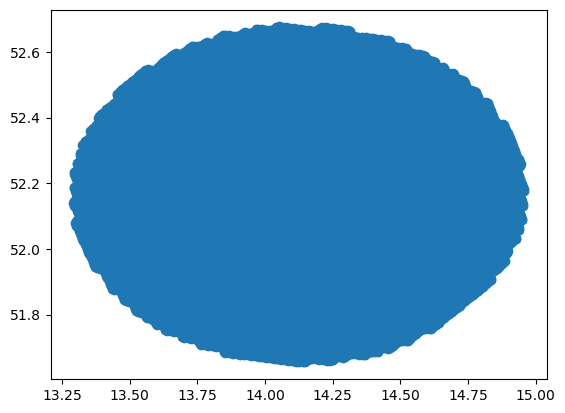

In [31]:
import matplotlib.pyplot as plt
grid  = icr.read_grid(1)
plt.scatter(grid['lon_cell_centre'],grid['lat_cell_centre'])
#plt.xlim(14.0,14.1)
#plt.ylim(52.19,52.20)
print(grid['lon_cell_centre'].min(),
grid['lon_cell_centre'].max(),
grid['lat_cell_centre'].min(),
grid['lat_cell_centre'].max())

In [10]:
TT_data[0].values.shape

(41636,)

In [18]:
TT_data = icr.read_les(t.year,t.month,t.day,14,0,'TT',domain)
TT_data.min().min()

8.939300537109375

In [1]:
nx

NameError: name 'nx' is not defined

In [6]:
grid

,lon_cell_centre,lat_cell_centre
0,14.246001,52.310890
1,14.242536,52.311253
2,14.243924,52.310479
3,14.248438,52.308133
4,14.247050,52.308907
...,...,...
41631,14.268967,52.286003
41632,14.270353,52.285229
41633,14.270014,52.284020
41634,14.285250,52.281789


In [80]:
maindir = '/work/um0203/u300510/fesstval/icon/'
filename = maindir+'network_interpolated/t_2m_interp_icon_dom04_20210629.nc'
ds = xr.open_dataset(filename)

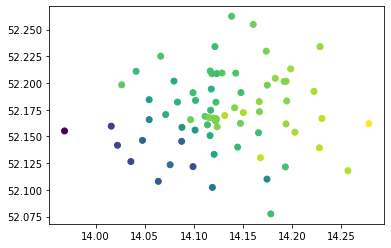

In [83]:
plt.scatter(ds['lon'],ds['lat'],c=ds['ta'])

In [7]:
d.date()

datetime.date(2021, 6, 15)

In [93]:
TT_interpolated.columns.to_numpy(dtype='S5')

array([b'001Sa', b'002Ba', b'003Ba', b'004Ba', b'005Ba', b'006Ba',
       b'008Ca', b'009Ca', b'012Ca', b'013Ca', b'014Ca', b'015Ca',
       b'016Da', b'017Da', b'018Da', b'019Da', b'020Da', b'021Da',
       b'022Da', b'023Da', b'024Da', b'026Da', b'027Da', b'028Ea',
       b'029Ea', b'030Ea', b'031Ea', b'033Ea', b'036Ea', b'037Ea',
       b'038Ea', b'039Ea', b'041Ea', b'042Fa', b'043Fa', b'044Fa',
       b'045Fa', b'046Fa', b'047Fa', b'048Fa', b'049Fa', b'050Fa',
       b'051Fa', b'053Fa', b'054Fa', b'055Fa', b'056Fa', b'057Fa',
       b'059Ga', b'060Ga', b'061Ga', b'062Ga', b'064Ga', b'065Ga',
       b'067Ga', b'068Ga', b'069Ga', b'070Ga', b'072Ga', b'074Ga',
       b'075Ha', b'077Ha', b'078Ha', b'080Ha', b'081Ha', b'083Ha',
       b'084Ha', b'085Ha', b'087Ha', b'089Ha', b'090Ha', b'091Ha',
       b'092Ha', b'093Sa', b'095Sa', b'096Sa', b'098Sa', b'099Sa',
       b'101Sa', b'102Sa', b'007Cw', b'011Cw', b'025Dw', b'032Ew',
       b'035Ew', b'040Ew', b'052Fw', b'058Gw', b'063Gw', b'066

In [10]:
importlib.reload(icr)

<module 'icon_routines' from '/work/um0203/u300510/fesstval/icon/icon_routines.py'>

In [14]:
icr.check_sim_day(dt.date(2021,6,29))

True

In [42]:
xr.open_dataset('/work/um0203/u300510/fesstval/icon/grid_interpolated/ta_grid_icon_dom01_20210629.nc')

<xarray.Dataset>
Dimensions:  (time: 96, lon: 41, lat: 41)
Coordinates:
  * time     (time) datetime64[ns] 2021-06-29 ... 2021-06-29T23:45:00
  * lon      (lon) float32 13.83 13.84 13.86 13.87 ... 14.37 14.39 14.4 14.42
  * lat      (lat) float32 51.99 52.0 52.0 52.01 ... 52.32 52.33 52.34 52.35
Data variables:
    x        (lon) float32 ...
    y        (lat) float32 ...
    mask     (lon, lat) int16 ...
    ta       (time, lon, lat) float32 ...
Attributes:
    Title:            ICON LES FESSTVaLD2 simulation interpolated to Cartesia...
    Institution:      Meteorological Institute, University of Hamburg (UHH), ...
    Contact_person:   Bastian Kirsch (bastian.kirsch@uni-hamburg.de)
    Source:           Simulation data located on Levante at /pool/data/fesstv...
    History:          None
    Conventions:      CF-1.7 where applicable
    Processing_date:  2023-05-17 14:06:25 UTC
    Author:           Bastian Kirsch (bastian.kirsch@uni-hamburg.de)
    Comments:         None
    Licence:          This data is licensed under a Creative Commons Attribut...

In [14]:
ds = icr.read_les(2021,6,29,15,0,'TT',3,mute=False,return_ds=True)

In [31]:
ds['sodifd_s']

<xarray.DataArray 'sodifd_s' (time: 1, ncells: 41636)>
array([[      nan,       nan,       nan, ..., 137.66203, 135.23167, 138.366  ]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2021-06-29T15:00:00
Dimensions without coordinates: ncells
Attributes:
    standard_name:                sodifd_s
    long_name:                    shortwave diffuse downward flux at surface
    units:                        W m-2
    param:                        199.4.0
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

In [1]:
import geopy

In [2]:
import pykrige

In [14]:
icr.read_network()


,LAT,LON,X,Y
NAME,,,,
001Sa,52.16665,14.12292,0.00000,0.00000
002Ba,52.17447,14.11710,-398.16907,870.15042
003Ba,52.16954,14.13145,583.58475,321.74329
004Ba,52.15904,14.12375,56.77977,-846.80381
005Ba,52.16083,14.11384,-621.35456,-647.30627
...,...,...,...,...
086Hw,52.05383,13.97941,-9844.14519,-12553.38245
088Hw,52.15989,13.90631,-14823.27815,-752.14860
094Sw,52.16431,14.12218,-50.63896,-260.19597


In [19]:
lon_ref_grid,lat_ref_grid = meta_data[meta_data.index == '001Sa'][['LON','LAT']].squeeze()

In [20]:
lon_ref_grid


14.12292

In [8]:
y_grid_icon

array([16049.84412011, 16090.28860321, 16004.15078369, ...,
       13059.90553789, 12811.64892009, 12897.80459235])

In [23]:
TT_data

,0
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
41631,25.218384
41632,25.221100
41633,25.261719
41634,25.512756


In [24]:
grid['lon_cell_centre']

0        14.246001
1        14.242536
2        14.243924
3        14.248438
4        14.247050
           ...    
41631    14.268967
41632    14.270353
41633    14.270014
41634    14.285250
41635    14.283864
Name: lon_cell_centre, Length: 41636, dtype: float64

In [25]:
plt.scatter(grid['lon_cell_centre'],grid['lat_cell_centre'])

NameError: name 'plt' is not defined

In [1]:
TT_regridded

NameError: name 'TT_regridded' is not defined

In [2]:
times_day

NameError: name 'times_day' is not defined

In [10]:
TT_grid

array([[27.456177, 28.00476 , 28.421692, ..., 28.714447, 28.409058,
        28.511688],
       [27.434113, 28.026917, 28.101166, ..., 28.717102, 28.477081,
        28.67749 ],
       [27.048615, 27.843475, 28.403809, ..., 28.701843, 28.572357,
        28.725708],
       ...,
       [29.040741, 29.117584, 29.378418, ..., 31.075562, 30.824982,
        30.78183 ],
       [29.016968, 29.11441 , 29.232574, ..., 30.660156, 30.713837,
        30.755737],
       [28.886627, 29.126526, 29.04889 , ..., 30.39093 , 30.473969,
        30.687378]], dtype=float32)

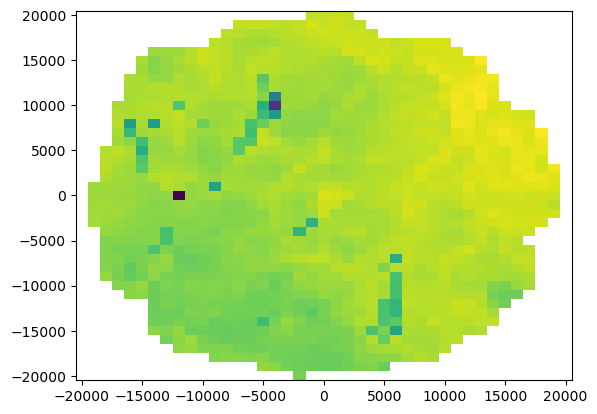

In [23]:
import matplotlib.pyplot as plt
plt.pcolormesh(x_meshgrid,y_meshgrid,TT_ip_grid[:,:,0])

In [38]:
fdir = '/work/um0203/u300510/fesstval/icon/network_interpolated/'
flist = os.listdir(fdir)
for f in flist:
    if 'interp' in f:
        f_new = f.replace('interp','network')
        print(f,f_new)
        os.rename(fdir+f,fdir+f_new)

ta_interp_icon_dom04_20210630.nc ta_network_icon_dom04_20210630.nc
ta_interp_icon_dom03_20210629.nc ta_network_icon_dom03_20210629.nc
ta_interp_icon_dom01_20210626.nc ta_network_icon_dom01_20210626.nc
ta_interp_icon_dom02_20210612.nc ta_network_icon_dom02_20210612.nc
ta_interp_icon_dom03_20210628.nc ta_network_icon_dom03_20210628.nc
ta_interp_icon_dom04_20210528.nc ta_network_icon_dom04_20210528.nc
ta_interp_icon_dom04_20210711.nc ta_network_icon_dom04_20210711.nc
ta_interp_icon_dom03_20210618.nc ta_network_icon_dom03_20210618.nc
ta_interp_icon_dom03_20210615.nc ta_network_icon_dom03_20210615.nc
ta_interp_icon_dom03_20210624.nc ta_network_icon_dom03_20210624.nc
ta_interp_icon_dom01_20210625.nc ta_network_icon_dom01_20210625.nc
ta_interp_icon_dom04_20210610.nc ta_network_icon_dom04_20210610.nc
ta_interp_icon_dom04_20210621.nc ta_network_icon_dom04_20210621.nc
ta_interp_icon_dom02_20210625.nc ta_network_icon_dom02_20210625.nc
ta_interp_icon_dom01_20210530.nc ta_network_icon_dom01_2021053